### Build a DNN for ECG Signal Classification (5 classes)  - Pytorch
This is the implementation of an MLP for classifying the ECG signals. <br>
Your task is to design new DNNs for ECG signal classification <br>
You can use this file as a template

In [132]:
#LUKE CAPRIO


In [107]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torch.utils.data import DataLoader as torch_dataloader
from torch.utils.data import Dataset as torch_dataset
import torch.optim as optim

## The Neural Network: MLP  

In [108]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32,kernel_size=5, stride=2, padding=1)
        self.pool1 = nn.AvgPool1d(kernel_size = 2, padding = 0)
        
        self.conv2 = nn.Conv1d(32,32,5,2,1)
        self.pool2 = nn.AvgPool1d(kernel_size = 2)
        
        self.norm3 = nn.BatchNorm1d(32)
        self.conv3 = nn.Conv1d(32,32,5,2,2)
        self.pool3 = nn.AvgPool1d(kernel_size = 2)
        
        self.norm4 = nn.BatchNorm1d(32)
        self.conv4 = nn.Conv1d(32,32,5,2,1)
        
        self.norm5 = nn.BatchNorm1d(32)
        self.conv5 = nn.Conv1d(32,32,5,1,0)
        
        self.fc1 = nn.Linear(in_features=224, out_features=64)
        self.fc2 = nn.Linear(64, 5)
        
        
    def forward(self, x):
        x = x.view(x.size(0),1,x.size(1))
        
        y1 = nnF.relu(self.conv1(x))
        #print("y1", y1.shape)
        x1 = self.pool1(y1)
        #print("x1", x1.shape)
        
        
        y2 = nnF.relu(self.conv2(y1))
        y2 = y2 + x1
        #print("y2", y2.shape)
        x2 = self.pool2(y2)
        #print("x2", x2.shape)
        
        
        y3 = self.norm3(y2)
        y3 = nnF.relu(self.conv3(y3))
        y3 = y3 + x2
        #print("y3", y3.shape)
        x3 = self.pool3(y3)
        #print("x3", x3.shape)
        
        
        y4 = self.norm4(y3)
        #print("y4", y4.shape)
        y4 = nnF.relu(self.conv4(y4))
        x4 = self.pool3(y3)
        #print("x4", x4.shape)
        y4 = y4 + x3
        
        y5 = self.norm5(y4)
        y5 = nnF.relu(self.conv5(y5))
        #print("y5", y5.shape)
        
        
        x = y5.view(y5.size(0),-1)
    
        
        x = nnF.relu(self.fc1(x))
        
        z = nnF.relu(self.fc2(x))
        #y=nnF.softmax(z, dim=1)
        return z

In [109]:
#debug your network here
#make sure it works for one single input sample
model=Net()

x=torch.rand(10,187) # if network is MLP
#x=torch.rand(10,1,187) #if network is CNN
z=model(x)

In [110]:
def save_checkpoint(filename, model, optimizer, result, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'result':result},
               filename)
    print('saved:', filename)

In [111]:
def cal_accuracy(confusion):
    #input: confusion is the confusion matrix
    #output: acc is the standard classification accuracy
    M=confusion.copy().astype('float32')
    acc = M.diagonal().sum()/M.sum()    
    sens=np.zeros(M.shape[0])
    prec=np.zeros(M.shape[0]) 
    for n in range(0, M.shape[0]):
        TP=M[n,n]
        FN=np.sum(M[n,:])-TP
        FP=np.sum(M[:,n])-TP
        sens[n]=TP/(TP+FN)
        prec[n]=TP/(TP+FP)       
    return acc, sens, prec

## The function to train the model

In [112]:
def train(model, device, optimizer, dataloader, epoch):    
    model.train()#set model to training mode
    loss_train=0
    acc_train =0 
    sample_count=0
    for batch_idx, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()#clear grad of each parameter
        Z = model(X)#forward pass
        loss = nnF.cross_entropy(Z, Y)
        loss.backward()#backward pass
        optimizer.step()#update parameters
        loss_train+=loss.item()
        #do not need softmax
        Yp = Z.data.max(dim=1)[1]  # get the index of the max               
        acc_train+= torch.sum(Yp==Y).item()
        sample_count+=X.size(0)
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}'.format(
                    epoch, 100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    #due to upsampling, len(dataloader.dataset) != sample_count
    #acc_train/=len(dataloader.dataset) 
    acc_train/=sample_count    
    return loss_train, acc_train

## The Function to test the model

In [113]:
def test(model, device, dataloader):
    model.eval()#set model to evaluation mode
    acc_test =0
    confusion=np.zeros((5,5))
    with torch.no_grad(): # tell Pytorch not to build graph in the with section
        for batch_idx, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            Z = model(X)#forward pass
            #do not need softmax
            Yp = Z.data.max(dim=1)[1]  # get the index of the max 
            acc_test+= torch.sum(Yp==Y).item()
            for i in range(0, 5):
                for j in range(0, 5):
                    confusion[i,j]+=torch.sum((Y==i)&(Yp==j)).item()
    acc, sens, prec=cal_accuracy(confusion)
    return acc, (confusion, sens, prec)

## Load data and create dataloaders

In [114]:
class MyDataset(torch_dataset):
    def __init__(self, X, Y):
        self.X=X
        self.Y=Y
    def __len__(self):
        #return the number of data points
        return self.X.shape[0]
    def __getitem__(self, idx):        
        #we can use DatasetName[idx] to get a data point (x,y) with index idx
        x=torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.Y[idx], dtype=torch.int64)
        #x=x.reshape(1,-1) if network is CNN
        return x, y

In [115]:
import pandas as pd
X=pd.read_csv('ECG_dataX.csv')
Y=pd.read_csv('ECG_dataY.csv')

In [116]:
#convert dataframe to numpy array
X=X.values
X.shape

(3841, 187)

In [117]:
#convert dataframe to numpy array
Y=Y.values
Y.shape

(3841, 1)

In [118]:
#reshape Y into a 1D array
Y=Y.reshape(-1)
Y.shape

(3841,)

(array([800.,   0., 800.,   0.,   0., 800.,   0., 641.,   0., 800.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

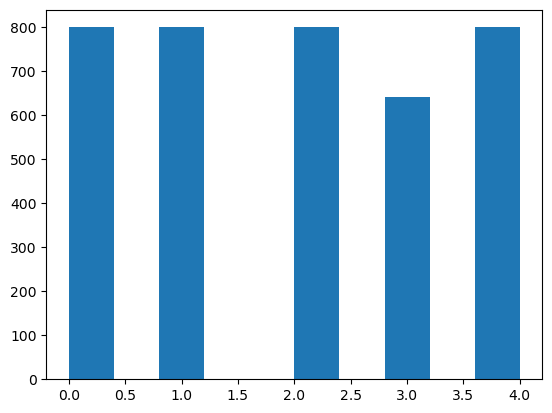

In [119]:
plt.hist(Y)

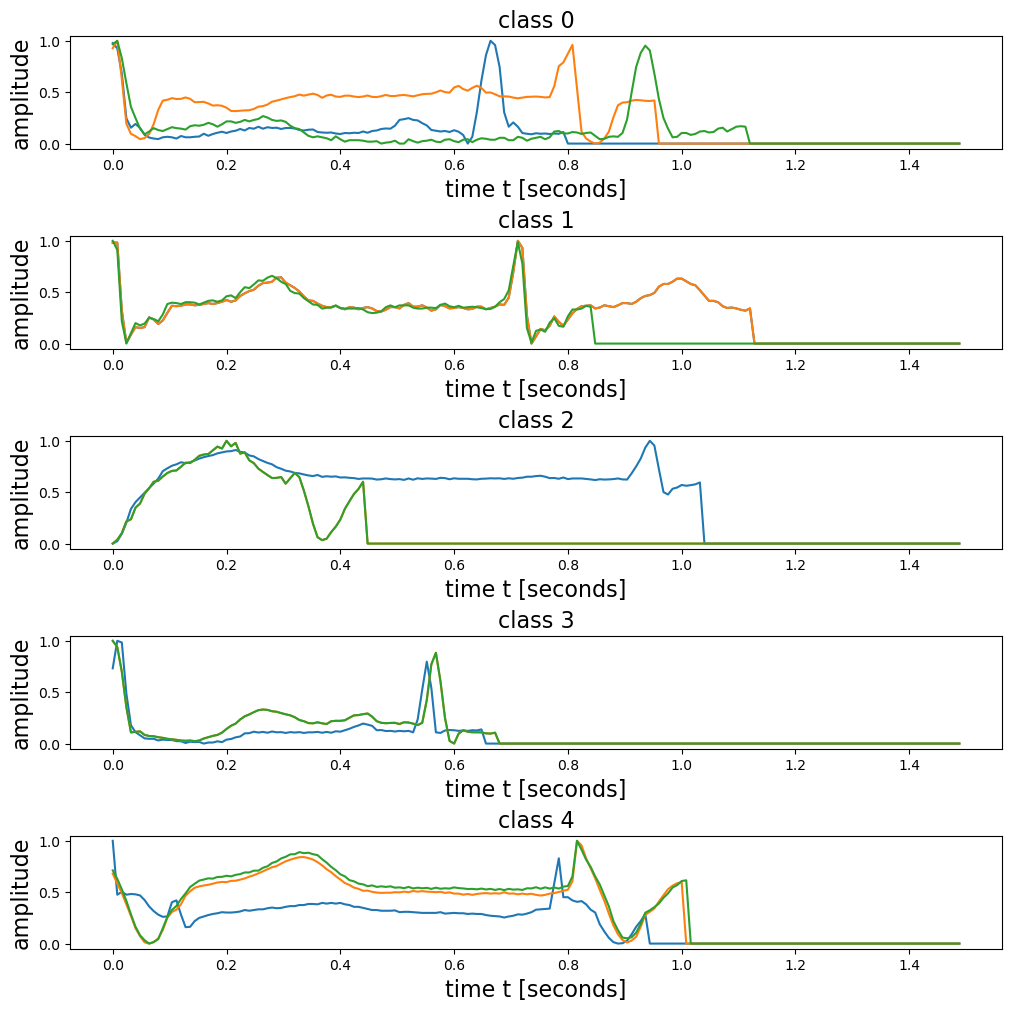

In [120]:
fs=125  # sampling frequency
Ts=1/fs # sampling interval
N=187 # the number of timepoints
Duration=N*Ts # duration of a signal
t=np.linspace(0, Duration-Ts, N) # array of timepoints
fig, ax = plt.subplots(5,1,constrained_layout=True, figsize=(10,10))
for c in range(0, 5):   
    for n in range(0, 3):
        idx=np.random.randint(0,10)
        ax[c].plot(t, X[Y==c][idx])        
        ax[c].set_xlabel('time t [seconds]', fontsize=16)
        ax[c].set_ylabel('amplitude', fontsize=16)
    ax[c].set_title('class '+str(c), fontsize=16)

In [121]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)

In [122]:
dataset_train=MyDataset(X_train, Y_train)
dataset_val=MyDataset(X_val, Y_val)
dataset_test=MyDataset(X_test, Y_test)

In [123]:
loader_train = torch_dataloader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
loader_val = torch_dataloader(dataset_val, batch_size=128, shuffle=False, num_workers=0) 
loader_test = torch_dataloader(dataset_test, batch_size=128, shuffle=False, num_workers=0) 

## Create a model, and start the traning-validation-testing process

In [124]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model=Net()
model.to(device)
#the code below may cause error if BatchNorm is used, you may delete those without affecting the rest of the file
#x=dataset_train[0][0]
#x=x.view(1,1,187).to(device) #change it to x=x.view(1,1,187).to(device) for CNN
#z=model(x)

Net(
  (conv1): Conv1d(1, 32, kernel_size=(5,), stride=(2,), padding=(1,))
  (pool1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv2): Conv1d(32, 32, kernel_size=(5,), stride=(2,), padding=(1,))
  (pool2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (norm3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(32, 32, kernel_size=(5,), stride=(2,), padding=(2,))
  (pool3): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (norm4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(32, 32, kernel_size=(5,), stride=(2,), padding=(1,))
  (norm5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
  (fc1): Linear(in_features=224, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=5, bias=True)
)

use stochastic gradient descent as the optimization method

In [125]:
optimizer = optim.Adamax(model.parameters(), lr=0.001, weight_decay=1e-4)

In [126]:
loss_train_list=[]
acc_train_list=[]
acc_val_list=[]
epoch_save=-1

train/val/test over many epochs

In [127]:
for epoch in range(epoch_save+1, 100): #change 100 to a larger number if necessary
    #-------- training --------------------------------
    loss_train, acc_train =train(model, device, optimizer, loader_train, epoch)    
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    #-------- validation --------------------------------
    acc_val, other_val = test(model, device, loader_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation acc:', acc_val)
    #--------save model-------------------------
    result = (loss_train_list, acc_train_list, 
              acc_val_list, other_val)
    save_checkpoint('LUKECAPRIO_ECG_CNN_Pytorch_epoch'+str(epoch)+'.pt', model, optimizer, result, epoch)
    epoch_save=epoch

Train Epoch: 0 [0%]	Loss: 1.614551
epoch 0 training loss: 1.3941914276643232 acc: 0.5307525325615051
epoch 0 validation acc: 0.4318182
saved: LUKECAPRIO_ECG_CNN_Pytorch_epoch0.pt
Train Epoch: 1 [0%]	Loss: 1.192519
epoch 1 training loss: 0.9457393938844855 acc: 0.6877713458755427
epoch 1 validation acc: 0.65584415
saved: LUKECAPRIO_ECG_CNN_Pytorch_epoch1.pt
Train Epoch: 2 [0%]	Loss: 0.800781
epoch 2 training loss: 0.684090562842109 acc: 0.7543415340086831
epoch 2 validation acc: 0.6980519
saved: LUKECAPRIO_ECG_CNN_Pytorch_epoch2.pt
Train Epoch: 3 [0%]	Loss: 0.618899
epoch 3 training loss: 0.5651168064637617 acc: 0.7869030390738061
epoch 3 validation acc: 0.7564935
saved: LUKECAPRIO_ECG_CNN_Pytorch_epoch3.pt
Train Epoch: 4 [0%]	Loss: 0.457292
epoch 4 training loss: 0.4936907928098332 acc: 0.8162083936324168
epoch 4 validation acc: 0.78571427
saved: LUKECAPRIO_ECG_CNN_Pytorch_epoch4.pt
Train Epoch: 5 [0%]	Loss: 0.591749
epoch 5 training loss: 0.44088957526467065 acc: 0.8411722141823444
ep

Train Epoch: 45 [0%]	Loss: 0.033002
epoch 45 training loss: 0.02233608678745275 acc: 0.9952966714905933
epoch 45 validation acc: 0.8636364
saved: LUKECAPRIO_ECG_CNN_Pytorch_epoch45.pt
Train Epoch: 46 [0%]	Loss: 0.014174
epoch 46 training loss: 0.019184313714504242 acc: 0.9952966714905933
epoch 46 validation acc: 0.8538961
saved: LUKECAPRIO_ECG_CNN_Pytorch_epoch46.pt
Train Epoch: 47 [0%]	Loss: 0.014185
epoch 47 training loss: 0.020353216169909996 acc: 0.9952966714905933
epoch 47 validation acc: 0.8603896
saved: LUKECAPRIO_ECG_CNN_Pytorch_epoch47.pt
Train Epoch: 48 [0%]	Loss: 0.007102
epoch 48 training loss: 0.022006145233965733 acc: 0.9942112879884226
epoch 48 validation acc: 0.8668831
saved: LUKECAPRIO_ECG_CNN_Pytorch_epoch48.pt
Train Epoch: 49 [0%]	Loss: 0.011190
epoch 49 training loss: 0.01840555272065103 acc: 0.9963820549927641
epoch 49 validation acc: 0.8701299
saved: LUKECAPRIO_ECG_CNN_Pytorch_epoch49.pt
Train Epoch: 50 [0%]	Loss: 0.028020
epoch 50 training loss: 0.017680553169074

Train Epoch: 90 [0%]	Loss: 0.001019
epoch 90 training loss: 0.004899149165298281 acc: 0.998191027496382
epoch 90 validation acc: 0.8668831
saved: LUKECAPRIO_ECG_CNN_Pytorch_epoch90.pt
Train Epoch: 91 [0%]	Loss: 0.006239
epoch 91 training loss: 0.005048947175964713 acc: 0.9978292329956585
epoch 91 validation acc: 0.8701299
saved: LUKECAPRIO_ECG_CNN_Pytorch_epoch91.pt
Train Epoch: 92 [0%]	Loss: 0.027304
epoch 92 training loss: 0.009364531386050989 acc: 0.9974674384949349
epoch 92 validation acc: 0.8538961
saved: LUKECAPRIO_ECG_CNN_Pytorch_epoch92.pt
Train Epoch: 93 [0%]	Loss: 0.039283
epoch 93 training loss: 0.014289215323515236 acc: 0.9952966714905933
epoch 93 validation acc: 0.85714287
saved: LUKECAPRIO_ECG_CNN_Pytorch_epoch93.pt
Train Epoch: 94 [0%]	Loss: 0.011530
epoch 94 training loss: 0.014860902590126816 acc: 0.9942112879884226
epoch 94 validation acc: 0.8636364
saved: LUKECAPRIO_ECG_CNN_Pytorch_epoch94.pt
Train Epoch: 95 [0%]	Loss: 0.002925
epoch 95 training loss: 0.0254746103574

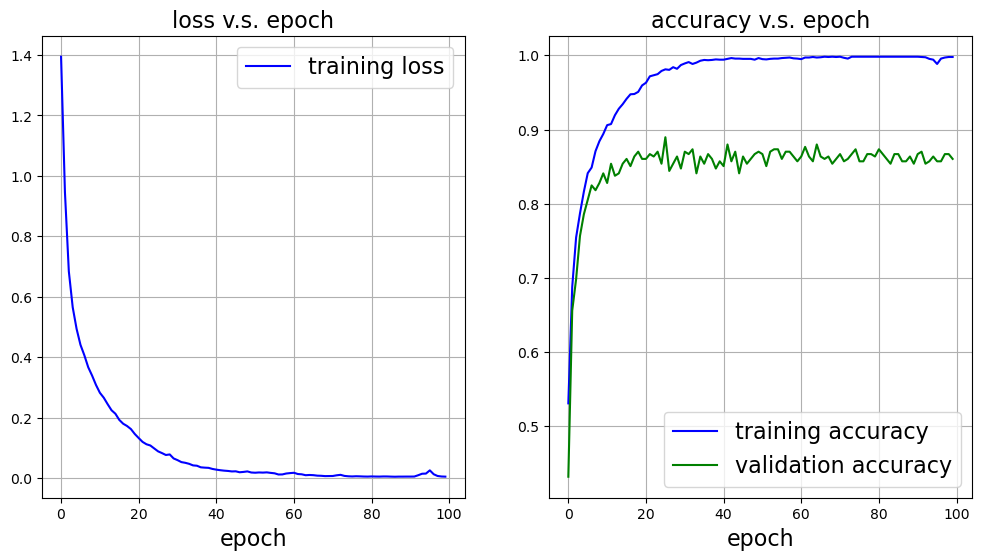

In [128]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].set_title('loss v.s. epoch',fontsize=16)
ax[0].plot(loss_train_list, '-b', label='training loss')
ax[0].set_xlabel('epoch',fontsize=16)
ax[0].legend(fontsize=16)
ax[0].grid(True)
ax[1].set_title('accuracy v.s. epoch',fontsize=16)
ax[1].plot(acc_train_list, '-b', label='training accuracy')
ax[1].plot(acc_val_list, '-g', label='validation accuracy')
ax[1].set_xlabel('epoch',fontsize=16)
ax[1].legend(fontsize=16)
ax[1].grid(True)

load the best model

In [129]:
best_epoch=np.argmax(acc_val_list)
best_epoch

25

In [130]:
checkpoint=torch.load('LUKECAPRIO_ECG_CNN_Pytorch_epoch'+str(best_epoch)+'.pt')
model=Net()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device);
model.eval();

In [131]:
#third try
acc, (confusion, sens, prec) = test(model, device, loader_test)
print('Accuracy (average)', acc)
print('Sensitivity', sens)
print('Precision', prec)
print('Confusion \n', confusion)

Accuracy (average) 0.9063719
Sensitivity [0.82954544 0.90259743 0.92465752 0.93442625 0.95321637]
Precision [0.85380119 0.82248521 0.95070422 0.94214875 0.98192769]
Confusion 
 [[146.  24.   3.   1.   2.]
 [ 14. 139.   1.   0.   0.]
 [  4.   0. 135.   6.   1.]
 [  5.   2.   1. 114.   0.]
 [  2.   4.   2.   0. 163.]]


In [25]:
acc, (confusion, sens, prec) = test(model, device, loader_test)
print('Accuracy (average)', acc)
print('Sensitivity', sens)
print('Precision', prec)
print('Confusion \n', confusion)

Accuracy (average) 0.8855657
Sensitivity [0.82954544 0.87012988 0.87671232 0.93442625 0.92982459]
Precision [0.82954544 0.8427673  0.92753625 0.85074627 0.98148149]
Confusion 
 [[146.  18.   4.   5.   3.]
 [ 14. 134.   1.   5.   0.]
 [  5.   3. 128.  10.   0.]
 [  6.   0.   2. 114.   0.]
 [  5.   4.   3.   0. 159.]]
